In [1]:
from transformers import Trainer,get_linear_schedule_with_warmup,RobertaTokenizer,BertForSequenceClassification,BitsAndBytesConfig
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import psutil
from sklearn.model_selection import train_test_split
from peft import prepare_model_for_kbit_training
from peft import get_peft_model
import time
from collections import defaultdict
import math

In [2]:
def print_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable:,}")
    print(f"Total parameters: {total:,}")
    print(f"Percentage of trainable params: {100 * trainable / total:.2f}%")

## Custom RoBERTa class needs work

In [3]:
import torch
import torch.nn as nn
from transformers import RobertaForSequenceClassification

class RobertaForSequenceClassificationWithCustomHead(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # Add a new custom layer, e.g., a small MLP after the original classifier
        self.custom_layer = nn.Sequential(
            nn.Linear(config.num_labels, 64),
            nn.ReLU(),
            nn.Linear(64, config.num_labels)
        )
    
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):

        # Remove any unexpected keys that RobertaForSequenceClassification won't accept
        accepted_keys = {"input_ids", "attention_mask", "labels", "token_type_ids", "position_ids", "head_mask", "inputs_embeds", "output_attentions", "output_hidden_states", "return_dict"}
        filtered_kwargs = {k: v for k, v in kwargs.items() if k in accepted_keys}

        # Safe call to parent forward
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            **filtered_kwargs
        )

        logits = outputs.logits
        custom_logits = self.custom_layer(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(custom_logits, labels)

        return type(outputs)(
            loss=loss,
            logits=custom_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [4]:
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassificationWithCustomHead.from_pretrained("roberta-base", num_labels=15)
print(model.config)
print_trainable_parameters(model)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Number of available GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available.")
device

# Pretrained RoBERTa tokenizer (e.g. roberta-base)
#pretrained_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Your custom tokenizer trained on OOL tokens
custom_tokenizer = RobertaTokenizer.from_pretrained('./tokenizer') # Try to remove Fast?

Some weights of RobertaForSequenceClassificationWithCustomHead were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'custom_layer.0.bias', 'custom_layer.0.weight', 'custom_layer.2.bias', 'custom_layer.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 51

In [5]:
custom_vocab = set(custom_tokenizer.get_vocab().keys())

new_tokens = list(custom_vocab)

print(f"Found {len(new_tokens)} new tokens to use.")

Found 30522 new tokens to use.


In [6]:
model.resize_token_embeddings(len(custom_tokenizer))

Embedding(30522, 768, padding_idx=1)

In [7]:
from peft import get_peft_model, LoraConfig, TaskType

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,     # or SEQ_2_SEQ_LM, TOKEN_CLS, etc.
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],  # Adjust for RoBERTa
)

model = get_peft_model(model, config)
print_trainable_parameters(model)
model.to(device)

Trainable parameters: 823,311
Total parameters: 110,319,853
Percentage of trainable params: 0.75%


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassificationWithCustomHead(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                   

In [8]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = pd.read_pickle('./saved_data/encoded_data.pck')
le = LabelEncoder()
data['target'] = le.fit_transform(data['Attack_type'])

data2 = pd.read_csv(".\data\Edge-IIoTset dataset\Selected dataset for ML and DL\ML-EdgeIIoT-dataset.csv")
columns = list(data2.columns[:-2])

In [9]:
with open("column_name_encoded_data.txt","w") as f:
    for _, row in data.iterrows():
        tokens = row['encoded_PPFLE'].split(" ")
        formatted = []
        for idx, (col, tok) in enumerate(zip(columns, tokens)):
            end_char = "." if idx == len(tokens) - 1 else ";"
            formatted.append(f"{col}: {tok}{end_char}")
        row_string = " ".join(formatted)
        f.write(row_string + "\n")
#'<s>','<pad>','</s>','<unk>','<mask>'

In [10]:
with open("column_name_encoded_data.txt", "r") as f:
    prompt_lines = f.readlines()

# Strip newline characters
prompt_lines = [prompt_line.strip() for prompt_line in prompt_lines]
prompt_data = {
    "encoded_PPFLE_prompt": prompt_lines, 'Attack_type': data['Attack_type'], 'Attack_label': data['Attack_label'], 'target': data['target']
}
prompt_df = pd.DataFrame(prompt_data)
prompt_df.sample(15)

,encoded_PPFLE_prompt,Attack_type,Attack_label,target
16719,frame.time: 34fcc380281e8f1b503025dfb2c1324f97...,Uploading,1,12
38267,frame.time: 13ec1c72eab7df750c1fb25c0869bb6660...,DDoS_HTTP,1,1
23730,frame.time: 003b13ebb1c550e2ab36092fe5712dccfd...,SQL_injection,1,11
94192,frame.time: b4e5fbeecf1495f73c79648963f71cab9d...,Backdoor,1,0
117694,frame.time: d2b187fe0450045c0cdd5d4c093b1ee537...,Normal,0,7
28454,frame.time: 218540b44a2f70092e67be2e0f9dbd6dd2...,SQL_injection,1,11
124135,frame.time: eebbd758c34c1afce15cd88d970a8dc871...,Normal,0,7
11499,frame.time: 86a340d10925b559d332983270aa305512...,Ransomware,1,10
36680,frame.time: c2b0d51f6622423aa7092b933bf0193779...,DDoS_HTTP,1,1
39169,frame.time: 2e604daf1f3f701c0f95c598dc120c6ebf...,DDoS_HTTP,1,1


In [11]:
train_set = prompt_df.sample(frac=0.7,random_state=42).reset_index(drop=True)

remaining = prompt_df.drop(train_set.index).reset_index(drop=True)

test_set = remaining.sample(frac=0.5,random_state=42).reset_index(drop=True)

val_set = remaining.drop(test_set.index).reset_index(drop=True)

print(train_set.shape,val_set.shape,test_set.shape)

(110460, 4) (23670, 4) (23670, 4)


In [12]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_set, test_set = train_test_split(prompt_df, test_size=test_ratio,stratify=prompt_df.iloc[:,-1], random_state=42)
train_set, val_set = train_test_split(train_set, test_size=val_ratio/(val_ratio+train_ratio),stratify=train_set.iloc[:,-1], random_state=42)

In [13]:
train_set.shape,val_set.shape,test_set.shape

((110460, 4), (23670, 4), (23670, 4))

In [14]:
TARGET_LIST = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
                'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
                'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
                'XSS']

In [15]:
prompt_df[prompt_df['Attack_type']=='Uploading'].head(5)

,encoded_PPFLE_prompt,Attack_type,Attack_label,target
13140,frame.time: 05293357ba325a590027981a9b59eb748a...,Uploading,1,12
13141,frame.time: da0992898db14d190c3b6f7c2c6c658259...,Uploading,1,12
13142,frame.time: 4d5b89f0a6797f41a5d0ee5b7b1cfe1327...,Uploading,1,12
13143,frame.time: 732fcefab7fb269fd8ae7bd4d3b3e28ec3...,Uploading,1,12
13144,frame.time: 9a7d459b7d8a0e5c070cb85c3b1bd0824a...,Uploading,1,12


class CustomDataset(Dataset):
  def __init__(self,encodings,df,max_len):
    self.encodings = encodings
    self.df = df
    self.max_len=max_len
    self.targets = self.df['target'].tolist()

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    target = self.targets[idx]
    encoding = self.encodings[idx]

    return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets':torch.tensor(target,dtype=torch.long)
    }

In [16]:
from datasets import load_dataset, Dataset
from transformers import RobertaTokenizerFast
import torch

# Define tokenization function
def tokenize_function(row):
    return custom_tokenizer(
        row["encoded_PPFLE_prompt"],               # replace with your actual column
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

# Tokenize entire dataset
train_set_enc = (Dataset.from_pandas(train_set)).map(tokenize_function, batched=True)
val_set_enc = (Dataset.from_pandas(val_set)).map(tokenize_function, batched=True)
test_set_enc = (Dataset.from_pandas(test_set)).map(tokenize_function, batched=True)

# Save to disk (recommended)
train_set_enc.save_to_disk('lora_roberta_train_encodings.pt')
val_set_enc.save_to_disk('lora_roberta_val_encodings.pt')
test_set_enc.save_to_disk('lora_roberta_test_encodings.pt')

Map:   0%|          | 0/110460 [00:00<?, ? examples/s]

Map:   0%|          | 0/23670 [00:00<?, ? examples/s]

Map:   0%|          | 0/23670 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/110460 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23670 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23670 [00:00<?, ? examples/s]

In [17]:
from datasets import load_dataset, Dataset
from datasets import load_from_disk

train_set_enc = load_from_disk('lora_roberta_train_encodings.pt')
print(len(train_set_enc))
val_set_enc = load_from_disk('lora_roberta_val_encodings.pt')
print(len(val_set_enc))
test_set_enc = load_from_disk('lora_roberta_test_encodings.pt')
print(len(test_set_enc))

110460
23670
23670


In [18]:
def set_dataset_format(dataset):
    dataset = dataset.rename_column('target', "labels")
    dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"]  # include "labels" column
    )
    return dataset

train_dataset = set_dataset_format(train_set_enc)
val_dataset = set_dataset_format(val_set_enc)
test_dataset = set_dataset_format(test_set_enc)

In [19]:
MAX_LEN=512
BATCH_SIZE=32

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=0

)

val_loader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

test_data = next(iter(train_loader))

print(test_data['input_ids'].shape)

labels = train_dataset["labels"]
print(f"Labels min, max: {labels.min(), labels.max()}")
print(f"Labels dtype: {labels.dtype}")

for batch in train_loader:
    print(f"batch.keys = {batch.keys()}, ")
    break

print(train_dataset['input_ids'][0])

torch.Size([32, 512])
Labels min, max: (tensor(0), tensor(14))
Labels dtype: torch.int64
batch.keys = dict_keys(['labels', 'input_ids', 'attention_mask']), 
tensor([   0,   74,   86,   69,   81,   73,   18,   88,   77,   81,   73,   30,
         423,  322,   74, 2149, 1648,   74,   24,   72,  327,   71,  517,   72,
        3352, 1806,   71, 2128,  279,  347,  407,  410,   31,  225,   77,   84,
          18,   87,   86,   71,   67,   76,   83,   87,   88,   30,  383,  274,
          28,   72,   29,  306,  883,  307,   27,   69,  753,   71,  874,   69,
         308,  268,   20,  317,   28,  270,   20,  263,  884,   31,  225,   77,
          84,   18,   72,   87,   88,   67,   76,   83,   87,   88,   30,  809,
         263,   20,   71,   29,  797,  344,  268,   25,  795,   26,   74,  807,
          72,   23,   73,   31,  739,   86,   84,   18,   72,   87,   88,   18,
          84,   86,   83,   88,   83,   67,   77,   84,   90,   24,   30,  620,
         618,  325,  621,  278,  321,   72,

for batch in dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

In [20]:
def load_chkpt(model,version):
  return model.load_state_dict(torch.load(f"./saved_model/securityRoBERTa{version}.0.pt",map_location=torch.device('cpu')))

import numpy as np

def train_model_peft(trainer,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  trainer.model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d["labels"].to(device)
    
    outputs = trainer.model(input_ids,attention_mask, labels=labels)
    logits = outputs.logits  # extract the logits tensor
    _,preds = torch.max(logits,dim=1)
    loss = loss_fn(logits,labels)

    correct_predictions+=torch.sum(preds==labels).cpu()

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(trainer.model.parameters(),max_norm=1.0)

    optimizer.step()
    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions/n_examples,np.mean(losses)

def evaluation_model_peft(trainer,data_loader,loss_fn,device,n_examples):
  trainer.model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    labels = d['label'].to(device)

    outputs = trainer.model(input_ids,attention_mask, labels=labels)
    logits = outputs.logits  # extract the logits tensor
    _,preds = torch.max(logits,dim=1)
    loss = loss_fn(logits,labels)

    correct_predictions+=torch.sum(preds==labels).cpu()

    losses.append(loss.item())

  return correct_predictions/n_examples,np.mean(losses)

In [21]:
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.epoch_train_losses = []
        self.epoch_train_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        
        if "loss" in logs:
            self.epoch_train_losses.append(logs["loss"])

        if "eval_accuracy" in logs:
            self.epoch_train_accuracies.append(logs["eval_accuracy"])

In [22]:
from transformers import Trainer
import torch
import numpy as np

class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
        self.best_val_acc = 0.0

    def evaluate_and_save(self, epoch, model_version):
        # Evaluate on validation set
        metrics = self.evaluate()
        print(metrics.keys())
        val_acc = metrics["eval_accuracy"]
        val_loss = metrics["eval_loss"]
        self.history["val_acc"].append(val_acc)
        self.history["val_loss"].append(val_loss)

        # Save best model
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.save_model(f"./saved_model/{model_version}{epoch+1}.0.pt")
            print(f"Saved best model at epoch {epoch+1} with val_acc={val_acc:.4f}")

    def log_training_epoch(self, train_loss, train_acc):
        self.history["train_loss"].append(train_loss)
        self.history["train_acc"].append(train_acc)

In [23]:
EPOCHS=3

In [24]:
optimizer_lora = torch.optim.AdamW(model.parameters(),lr=1e-5)
total_steps = len(train_loader)*EPOCHS

scheduler_lora = get_linear_schedule_with_warmup(
    optimizer_lora,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
from transformers import TrainingArguments

batch_size = 32
gradient_accumulation_steps = 4

# output dir 
model_version = "securityRoBERTa_BaseLoRA_"
model_dir = f"{model_version}"

training_args = TrainingArguments(
    run_name=model_version,
    output_dir=model_dir,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    num_train_epochs=1,
    lr_scheduler_type="constant",
    logging_dir=f"{model_dir}/logs",
    fp16=True,  # Enable mixed precision training
    dataloader_num_workers=4,  # Adjust based on your CPU capabilities
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    report_to="none",  # Disable reporting to avoid unnecessary overhead
    label_names=["labels"],
)

In [26]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
# The parameters after appling LoRA
print_trainable_parameters(model)

"""
# designing computing metrics as per our use case. (F1-Macro is essential and log-loss is optional)
def compute_metrics(p):
    predictions, labels = p.predictions, TARGET_LIST
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(TARGET_LIST, predictions)
    macro_f1 = f1_score(TARGET_LIST, predictions, average='macro')

    return {"accuracy": accuracy, "macro_f1": macro_f1}
"""

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}

model.to(device)

"""
# configure Trainer
trainer_lora = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
"""

Trainable parameters: 823,311
Total parameters: 110,319,853
Percentage of trainable params: 0.75%


'\n# configure Trainer\ntrainer_lora = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=val_dataset,\n    compute_metrics=compute_metrics\n)\n'

In [27]:
import json

In [28]:
from collections import defaultdict
import time

metrics_callback = MetricsCallback()

# New trainer
trainer_lora = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train for one epoch (Trainer handles batches internally)
    trainer_lora.train()

    trainer_lora.log_training_epoch(metrics_callback.epoch_train_losses[-1], metrics_callback.epoch_train_accuracies[-1])

    # Evaluate and potentially save best model
    trainer_lora.evaluate_and_save(
        epoch,
        model_version
    )

history_roberta_base_lora = trainer_lora.history

# Save full history and training time
end_time = time.time()
history_roberta_base_lora["training_time"].append(end_time - start_time)

torch.save(history_roberta_base_lora, "./saved_model/history_roberta_base_lora.pt")
print("Training complete and history saved.")



Epoch 1/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.816500,2.688894,0.063836,0.008001


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Saved best model at epoch 1 with val_acc=0.0638

Epoch 2/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.728400,2.668736,0.091888,0.011221


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Saved best model at epoch 2 with val_acc=0.0919

Epoch 3/3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,10.659000,2.655815,0.153992,0.017792


dict_keys(['eval_loss', 'eval_accuracy', 'eval_macro_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])
Saved best model at epoch 3 with val_acc=0.1540
Training complete and history saved.


%%time
history_roberta_base_lora = defaultdict(list)
best_accuracy_roberta_base_lora=0
print("1")

# Record start time
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch {epoch+1}/{EPOCHS}")
  train_acc_roberta_base_lora,train_loss_roberta_base_lora = train_model_peft(trainer_lora,train_loader,loss_fn,optimizer_lora,device,scheduler_lora,len(train_set))
  val_acc_roberta_base_lora,val_loss_roberta_base_lora = evaluation_model_peft(trainer_lora,val_loader,loss_fn,device,len(val_set))
  history_roberta_base_lora['train_acc'].append(train_acc_roberta_base_lora)
  history_roberta_base_lora['train_loss'].append(train_loss_roberta_base_lora)
  history_roberta_base_lora['val_acc'].append(val_acc_roberta_base_lora)
  history_roberta_base_lora['val_loss'].append(val_loss_roberta_base_lora)
  print(f"Train Loss {train_loss_roberta_base_lora} | Validation Loss {val_loss_roberta_base_lora} | Training Accuracy {train_acc_roberta_base_lora} | Validation Accuracy {val_acc_roberta_base_lora}")

  if val_acc_roberta_base_lora>best_accuracy_roberta_base_lora:
    trainer_lora.save_model(f"./saved_model/{model_version}{epoch+1}.0.pt")
    best_accuracy_roberta_base_lora = val_acc_roberta_base_lora

# Record end time
end_time = time.time()

# Calculate training time
history_roberta_base_lora['training_time'].append(end_time - start_time)

# Save
torch.save(history_roberta_base_lora, "./saved_model/history_roberta_base_lora.txt")

In [29]:
# Load
history_roberta_base_lora = torch.load("./saved_model/history_roberta_base_lora.pt", weights_only=False)

# Still a defaultdict with tensors
print(type(history_roberta_base_lora))  # defaultdict
print(type(history_roberta_base_lora['train_acc'][0]))  # torch.Tensor

<class 'collections.defaultdict'>
<class 'float'>


[10.8165, 10.7284, 10.659]


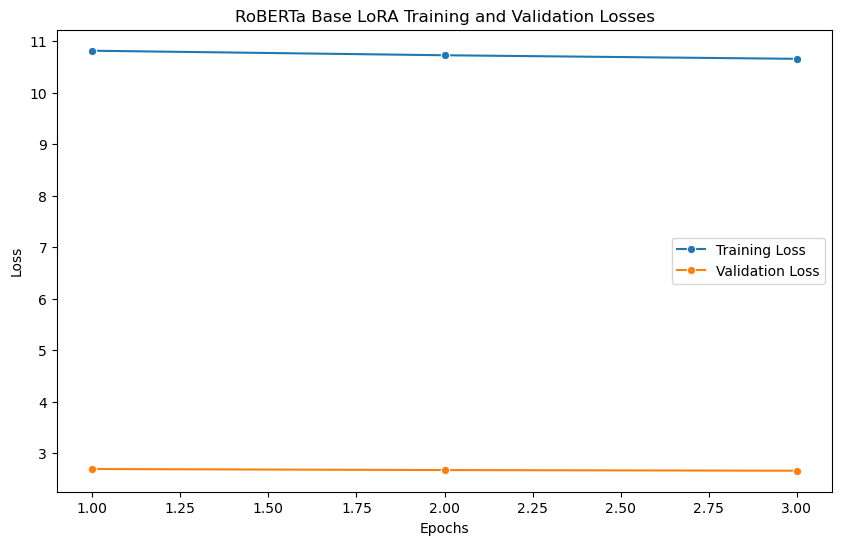

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = range(1, EPOCHS+1)
train_losses = history_roberta_base_lora['train_loss']
print(train_losses)
val_losses = history_roberta_base_lora['val_loss']

plt.figure(figsize=(10, 6))

sns.lineplot(x=epochs, y=train_losses, label='Training Loss',marker="o")
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss',marker="o")

plt.title('RoBERTa Base LoRA Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./roberta-base-lora-training-validation-losses.png',dpi=780)
plt.show()

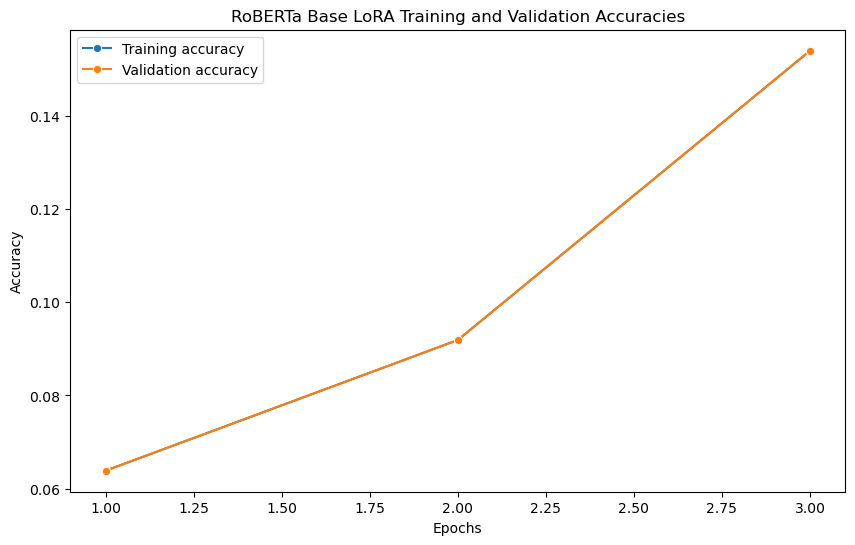

In [32]:
epochs = range(1, EPOCHS+1)
train_accuracies = history_roberta_base_lora['train_acc']
val_accuracies = history_roberta_base_lora['val_acc']

plt.figure(figsize=(10, 6))

sns.lineplot(x=epochs, y=train_accuracies, label='Training accuracy',marker='o')
sns.lineplot(x=epochs, y=val_accuracies, label='Validation accuracy',marker='o')

plt.title('RoBERTa Base LoRA Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./roberta-base-lora-training-validation-accuracies.png',dpi=780)
plt.show()

In [33]:
from transformers.trainer_utils import PredictionOutput
from sklearn.metrics import confusion_matrix,classification_report

def get_predictions(trainer, test_dataset):
    # Runs prediction
    output: PredictionOutput = trainer.predict(test_dataset)

    # Get raw logits and labels
    logits = torch.tensor(output.predictions)
    probs = F.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    labels = torch.tensor(output.label_ids)

    return preds, probs, labels

In [34]:
preds, probs, labels = get_predictions(trainer_lora, test_dataset)

In [35]:
torch.save(preds,"./saved_model/roberta_base_lora_predictions.pt")
torch.save(probs,"./saved_model/roberta_base_lora_predictions_probs.pt")
torch.save(labels,"./saved_model/roberta_base_lora_real_values.pt") 

In [36]:
target_names = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
       'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
       'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
       'XSS']

In [37]:
s = set()

In [38]:
for elt in preds:
  s.add(elt.item())

In [39]:
actual_considered_classes = [TARGET_LIST[i] for i in s]
actual_considered_classes

['Normal']

In [40]:
data['Attack_type'].value_counts()

Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64

In [41]:
def show_confusion_matrix(confusion_matrix):

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xticks(rotation=90)
    plt.title("RoBERTa Base LoRA Confusion Matrix")
    plt.ylabel('Real threats')
    plt.xlabel('Predicted threats')
    plt.savefig('./roberta-base-lora-confusion-matrix.png',dpi=780)
    plt.show()

In [42]:
print(classification_report(labels,preds,target_names=TARGET_LIST))

                       precision    recall  f1-score   support

             Backdoor       0.00      0.00      0.00      1529
            DDoS_HTTP       0.00      0.00      0.00      1584
            DDoS_ICMP       0.00      0.00      0.00      2114
             DDoS_TCP       0.00      0.00      0.00      1537
             DDoS_UDP       0.00      0.00      0.00      2175
       Fingerprinting       0.00      0.00      0.00       150
                 MITM       0.00      0.00      0.00       182
               Normal       0.15      1.00      0.27      3645
             Password       0.00      0.00      0.00      1498
        Port_Scanning       0.00      0.00      0.00      1511
           Ransomware       0.00      0.00      0.00      1639
        SQL_injection       0.00      0.00      0.00      1547
            Uploading       0.00      0.00      0.00      1540
Vulnerability_scanner       0.00      0.00      0.00      1511
                  XSS       0.00      0.00      0.00  

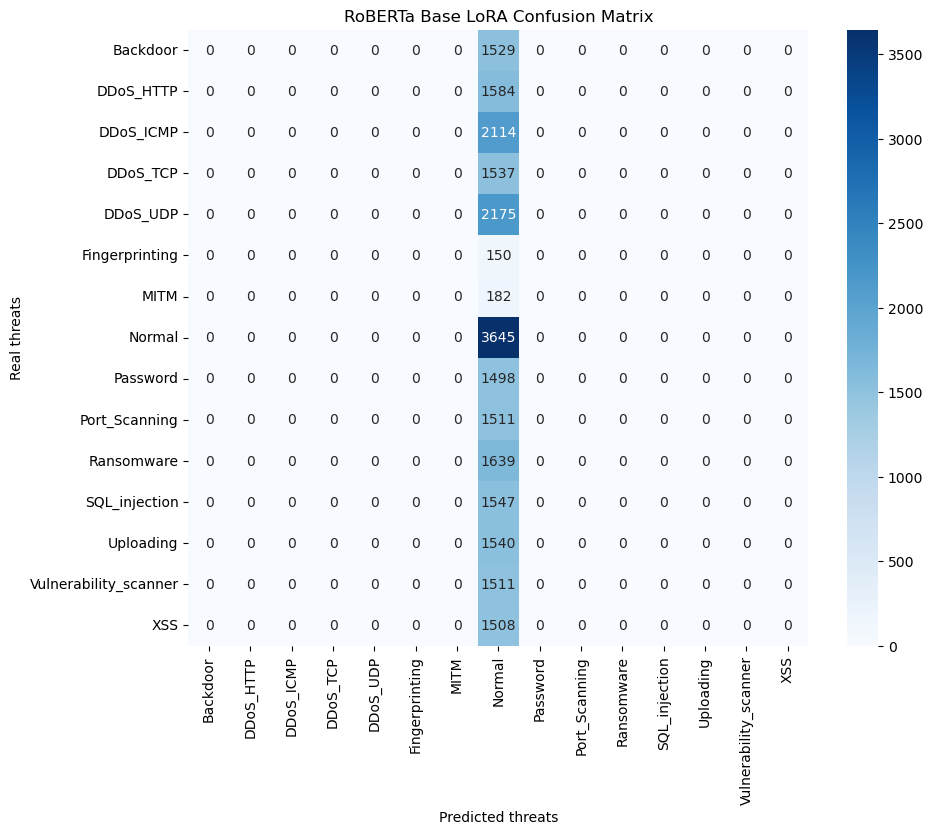

In [43]:
cm = confusion_matrix(labels,preds)
df_cm = pd.DataFrame(cm,index=TARGET_LIST,columns=TARGET_LIST)
show_confusion_matrix(df_cm)

In [44]:
y_true = labels.cpu().numpy()
y_score = preds.cpu().numpy()